### Regularization Exercises


In [188]:
# Generate a set of random number
import numpy as np
import pandas as pd
from functools import partial
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
import sklearn.model_selection as skm
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


### Question 1

In [39]:
# Preparing the Data

rng = np.random.default_rng(12345)
n = 100
generated = rng.normal(0,1,n)
noise = rng.normal(0,1,n)

power_range = np.arange(0,4)
beta = np.array([1,2,3,4])
vars = np.power.outer(generated, power_range)
response = vars @ beta + noise
power_range_data = np.arange(1,11)
data_gen = np.power.outer(generated, power_range_data)

data = pd.DataFrame(data_gen, columns=[f'X{i}' for i in power_range_data])
design = MS(data).fit(data)
x = design.transform(data)


In [50]:
def nCp(estimator, x, y, sigma) : 
    n,p = x.shape
    yhat = estimator.predict(x)
    rss = np.sum((y - yhat)**2)
    return -(rss + 2*p*sigma) / n

scale = sm.OLS(response, x).fit().scale
neg_nCp = partial(nCp, sigma=scale)
    

In [55]:
# Forward Strategy
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward, scoring=neg_nCp)
forward_fit.fit(data, response)

# Backward Strategy
backward = Stepwise.first_peak(design, direction="backwards", max_terms=len(design.terms))
backward_fit = sklearn_selected(sm.OLS, backward, scoring=neg_nCp)
backward_fit.fit(data, response)

print(f"Forward Selection : {forward_fit.selected_state_}")
print(f"Backward Selection : {backward_fit.selected_state_}")

Forward Selection : ('X1', 'X2', 'X3')
Backward Selection : ('X1', 'X2', 'X3')


In [ ]:
# Lasso Model
lambdas = np.logspace(-2, 2, 100)
cv = skm.ShuffleSplit(n_splits = 5, random_state=12345, test_size=0.2)
x_mean = x.mean()
x_std = x.std()
x_scaled = (x - x_mean) / x_std
x_scaled.dropna(axis=1, inplace=True)


(80,)
(80,)
(80,)
(80,)
(80,)


In [96]:
# lasso implementation
lasso_mse = []
k = 5
for l in lambdas : 
    cv_results = 0
    for train_idx, test_idx in cv.split(x_scaled) : 
        x_train = x_scaled.iloc[train_idx]
        y_train = response[train_idx]
        x_test = x_scaled.iloc[test_idx]
        y_test = response[test_idx]
        lasso = skl.ElasticNet(alpha=l, l1_ratio=1)
        lasso.fit(x_train, y_train)
        yhat = lasso.predict(x_test)
        mse = np.mean((yhat - y_test)**2)
        cv_results += mse
    cv_results /= k
    lasso_mse.append(cv_results)
    cv_results = 0
    
lasso_mse = np.array(lasso_mse)
lasso_mse.shape
        

(100,)

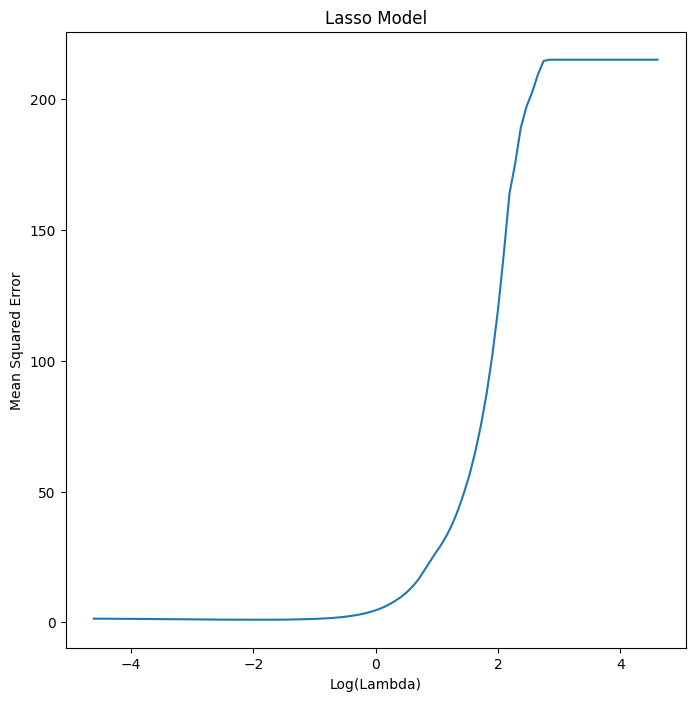

In [100]:
lasso_fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.log(lambdas), lasso_mse)
ax.set_xlabel("Log(Lambda)")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Model")
plt.show()


In [121]:
# Lasso Model 
optimal_lambda = lambdas[np.argmin(lasso_mse)]
lasso = skl.ElasticNet(alpha=optimal_lambda, l1_ratio=1)
lasso.fit(x_scaled, response)
lasso_coef = lasso.coef_
lasso_coef, optimal_lambda # Selects the first 3 variables with high power and rest with 0.046 and low power

(array([ 1.6168942 ,  3.13496577, 11.26560395,  0.0460943 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 0.1484968262254465)

In [124]:
# Implementing the automated approach
scaler = StandardScaler(with_mean=True, with_std=True)
lassoCV = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=cv)
pipe = Pipeline([('scaler', scaler), ('lasso', lassoCV)])
pipe.fit(x,response)
pipe.named_steps['lasso'].coef_, pipe.named_steps['lasso'].alpha_

# Yay Similar Results

(array([ 0.        ,  1.60965797,  3.12013917, 11.20895357,  0.04573009,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]),
 0.1484968262254465)

In [137]:
beta = np.array([1,2])
response_new = np.power.outer(generated, np.array([0,7])) @ beta + noise

# Implementing Lasso
pipe.fit(x,response_new)
pipe.named_steps['lasso'].coef_, pipe.named_steps['lasso'].alpha_

# Forward Selection
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward, scoring=neg_nCp)
forward_fit.fit(data, response_new)

# Backward Selection
backward = Stepwise.first_peak(design, direction="backwards", max_terms=len(design.terms))
backward_fit = sklearn_selected(sm.OLS, backward, scoring=neg_nCp)
backward_fit.fit(data, response_new)

print(f"Forward Selection : {forward_fit.selected_state_}")
print(f"Backward Selection : {backward_fit.selected_state_}")
print(f"Lasso : {pipe.named_steps['lasso'].coef_}")

# Woah Similar Results

Forward Selection : ('X5', 'X7', 'X9')
Backward Selection : ('X5', 'X7', 'X9')
Lasso : [  0.           1.67242508  -0.57043942 -18.20451232  -0.
  72.07503138   3.42405235  81.2018602    0.          47.34571737
   0.        ]


So forward, backward and lasso almost gets similar results, pretty close to the actual model. 

How did I implement : 
1. `Stepwise.first_peak()` : to define the strategy
2. `sklearn_selected()` : to implement the strategy
3. Standard For Loop with `cv.split()` to implement CV for lambda selection
4. `Scaler`, `skl.ElasticNetCV` and `Pipeline` to implement the lasso pipeline

What can be done more : 
1. `sklearn_selected_path()` : to get the path of the strategy
2. `skl.ElasticNetCV.path()` : to get the path of the strategy

Beware that the first two methods require ISLP's `ModelSpec` because they are implemented as a wrapper

#### Question 2

In [141]:
data = load_data("College")
data.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [143]:
design = MS(data.drop(columns="Apps"))
x = design.fit_transform(data)
y = data["Apps"]

In [157]:
cv = skm.ShuffleSplit(1, test_size=0.2, random_state=12345)

for train_idx, test_idx in cv.split(x) : 
    x_train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    x_test = x.iloc[test_idx]
    y_test = y.iloc[test_idx]
    model = sm.OLS(y_train, x_train).fit()
    yhat = model.predict(x_test)
    mse = np.mean((yhat - y_test)**2)
    print(f"MSE : {mse}")

MSE : 768308.325674253


In [187]:
lambdas = np.logspace(-2, 2, 100)
scaler = StandardScaler(with_mean=True, with_std=True)
cv = skm.ShuffleSplit(n_splits = 5, random_state=12345, test_size=0.2)
lassoCV = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=cv)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, cv=cv, l1_ratio=0)
pipeLasso = Pipeline([('scaler', scaler), ('lasso', lassoCV)])
pipeRidge = Pipeline([('scaler', scaler), ('ridge', ridgeCV)])
pipeLasso.fit(x,y)
pipeRidge.fit(x,y)

lasso_model = pipeLasso.named_steps['lasso']
ridge_model = pipeRidge.named_steps['ridge']

print(f"Lasso MSE : {np.min(-ridge_model.mse_path_.mean(axis=1))}")
print(f"Ridge MSE: {np.min(-ridge_model.mse_path_.mean(axis=1))}")
print(f"Lasso Coef : {lasso_model.coef_}")

# Everything is there almost. 1 Non Zero Coeff


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4959527851.282621, tolerance: 1025984.5679304345
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 reg

Lasso MSE : -14174254.753122836
Ridge MSE: -14174254.753122836
Lasso Coef : [ 0.00000000e+00 -2.20095009e+02  3.88433002e+03 -8.17320625e+02
  8.80019520e+02 -2.81609559e+02  2.77868073e+02  6.76199134e+01
 -3.45177311e+02  1.65507646e+02  3.44253232e+00  2.10367628e+01
 -1.41592843e+02 -4.89933582e+01  6.08587027e+01  2.16598452e+00
  4.06480382e+02  1.48771508e+02]


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.718e+08, tolerance: 1.162e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


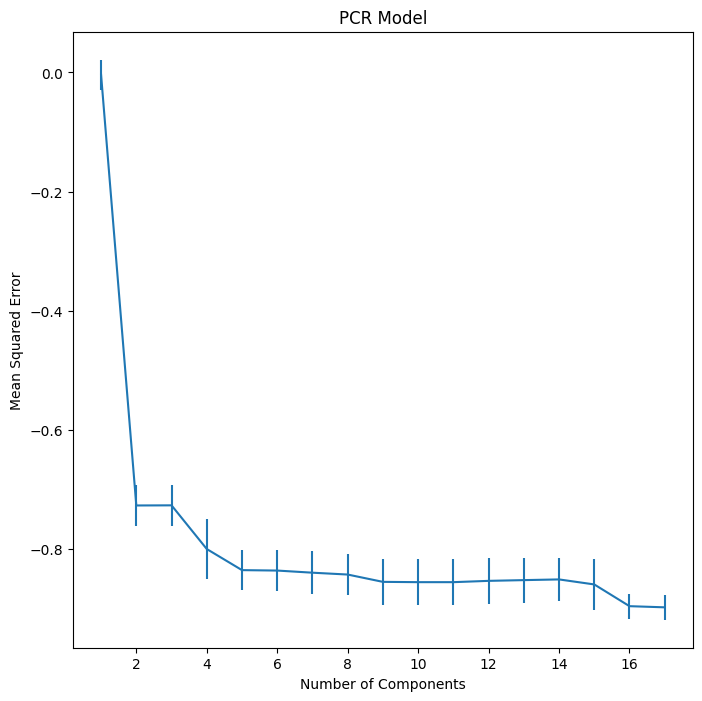

In [217]:
# PCR Model
pca = PCA()
pcr = PLSRegression()
linreg = skl.LinearRegression()
ncomps = np.arange(1, 18)
grid = {'pca__n_components': ncomps}
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
grid_search = skm.GridSearchCV(pipe, grid, cv=cv)
grid_search.fit(x,y)
grid_search.cv_results_

pls_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(ncomps, -grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score'])
ax.set_xlabel("Number of Components")
ax.set_ylabel("Mean Squared Error")
ax.set_title("PCR Model")
plt.show()

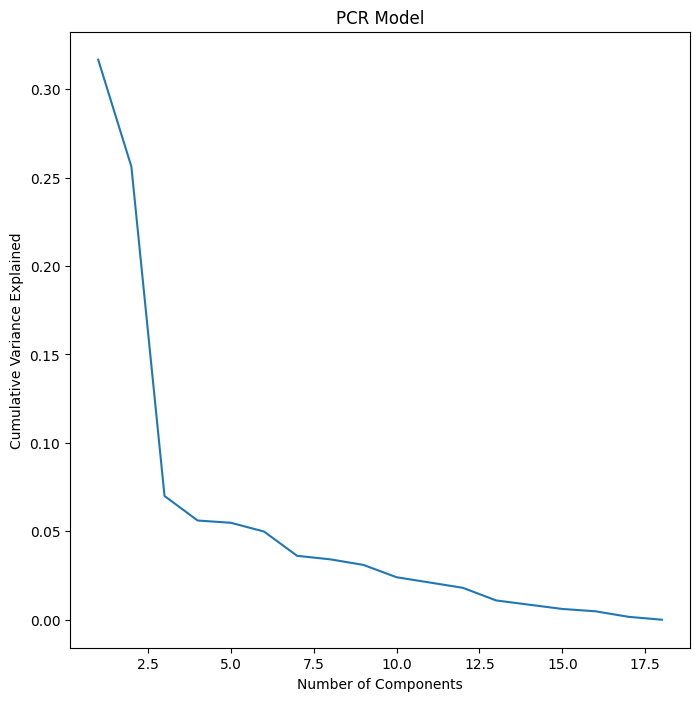

In [234]:
pca = PCA(n_components=18)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(x,y)

var_exp = np.array(pipe.named_steps['pca'].explained_variance_ratio_)
comps = np.arange(1,19)
cum_var_exp = np.cumsum(var_exp)

pcr_fig, ax = plt.subplots(figsize=(8,8))
ax.plot(comps, var_exp)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Variance Explained")
ax.set_title("PCR Model")
plt.show()


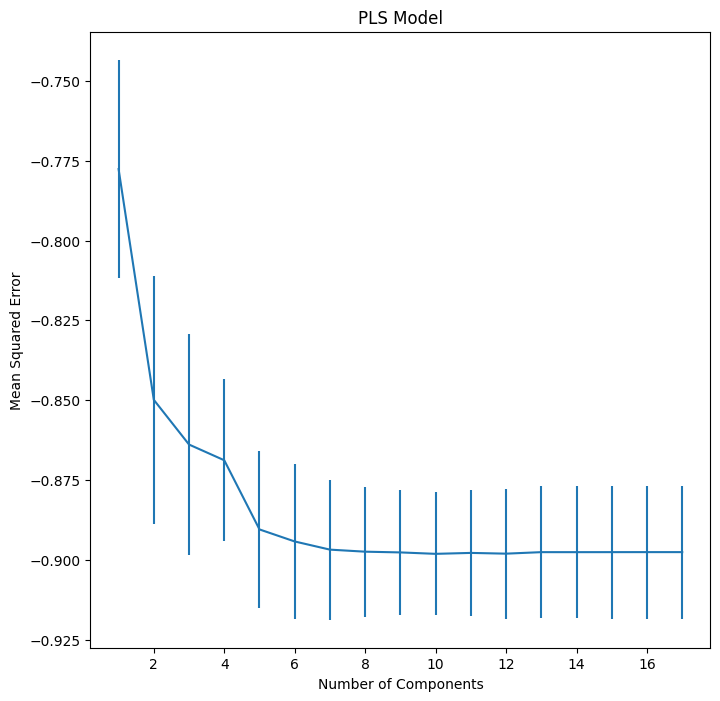

In [239]:
# PLS Regression
pls = PLSRegression()
ncomps = np.arange(1, 18)
grid = {'pls__n_components': ncomps}
pipe = Pipeline([('scaler', scaler), ('pls', pls)])
grid_search = skm.GridSearchCV(pipe, grid, cv=cv)
grid_search.fit(x,y)
grid_search.best_estimator_

pls_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(ncomps, -grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score'])
ax.set_xlabel("Number of Components")
ax.set_ylabel("Mean Squared Error")
ax.set_title("PLS Model")
plt.show()

### Task :  Interpret the results of all the models fitted

You have only learned to fit the model and find the best model, interpret the model now - make some inference